# Project 3: Applying CNN

### Group5: Jaxon Ham and Cody Uhl

In [10]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [11]:
class RazorbackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.filepaths = []
        self.labels = []

        # Folder 1: Razorback (label = 1)
        razor_dir = os.path.join(root_dir, "Razorback_Images")
        for filename in os.listdir(razor_dir):
            if filename.endswith(".jpg"):
                self.filepaths.append(os.path.join(razor_dir, filename))
                self.labels.append(1)

        # Folder 0: Non-Razorback (label = 0)
        non_dir = os.path.join(root_dir, "Non_Razorback_Images")
        for filename in os.listdir(non_dir):
            if filename.endswith(".jpg"):
                self.filepaths.append(os.path.join(non_dir, filename))
                self.labels.append(0)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        img_path = self.filepaths[index]
        label = self.labels[index]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [12]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((500, 500)),  # required by project
    transforms.ToTensor(),
])

transform_eval = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])

In [13]:
root = "./"   # folder containing Razorback_Images & Non_Razorback_Images

full_dataset = RazorbackDataset(root, transform_train)

# 70% train, 15% val, 15% test
torch.manual_seed(1)
train_size = int(0.7 * len(full_dataset))
valid_size = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - valid_size

train_ds, valid_ds, test_ds = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size, test_size]
)

# validation/test use evaluation transforms
valid_ds.dataset.transform = transform_eval
test_ds.dataset.transform = transform_eval

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16)
test_dl  = DataLoader(test_ds, batch_size=16)

print("Train:", len(train_ds))
print("Valid:", len(valid_ds))
print("Test:", len(test_ds))

Train: 35
Valid: 7
Test: 9


In [14]:
class RazorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(256 * (500//16) * (500//16), 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RazorCNN().to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [16]:
def train_model(model, train_dl, valid_dl, epochs=10):

    # HISTORY LISTS (must be lists!)
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(epochs):
        model.train()

        train_loss_sum = 0.0
        train_correct = 0

        # ---- TRAIN ----
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.float().to(device)

            pred = model(xb).squeeze()
            loss = loss_fn(pred, yb)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss_sum += loss.item() * xb.size(0)
            train_correct += ((pred >= 0.5).float() == yb).sum().item()

        epoch_train_loss = train_loss_sum / len(train_dl.dataset)
        epoch_train_acc = train_correct / len(train_dl.dataset)

        # ---- VALIDATION ----
        model.eval()
        valid_loss_sum = 0.0
        valid_correct = 0

        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.float().to(device)

                pred = model(xb).squeeze()
                loss = loss_fn(pred, yb)

                valid_loss_sum += loss.item() * xb.size(0)
                valid_correct += ((pred >= 0.5).float() == yb).sum().item()

        epoch_valid_loss = valid_loss_sum / len(valid_dl.dataset)
        epoch_valid_acc = valid_correct / len(valid_dl.dataset)

        # ---- STORE HISTORY ----
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        train_accs.append(epoch_train_acc)
        valid_accs.append(epoch_valid_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.3f} | "
            f"Val Loss: {epoch_valid_loss:.4f}, Val Acc: {epoch_valid_acc:.3f}"
        )

    return train_losses, valid_losses, train_accs, valid_accs

In [17]:
epochs = 10
train_losses, valid_losses, train_accs, valid_accs = train_model(model, train_dl, valid_dl, epochs=epochs)

Epoch 1/10 | Train Loss: 0.6955, Train Acc: 0.543 | Val Loss: 0.6964, Val Acc: 0.429
Epoch 2/10 | Train Loss: 0.6423, Train Acc: 0.543 | Val Loss: 0.6522, Val Acc: 0.857
Epoch 3/10 | Train Loss: 0.6296, Train Acc: 0.743 | Val Loss: 0.6308, Val Acc: 0.714
Epoch 4/10 | Train Loss: 0.6123, Train Acc: 0.714 | Val Loss: 0.6357, Val Acc: 0.571
Epoch 5/10 | Train Loss: 0.5529, Train Acc: 0.714 | Val Loss: 0.5729, Val Acc: 0.714
Epoch 6/10 | Train Loss: 0.5247, Train Acc: 0.743 | Val Loss: 0.4675, Val Acc: 0.857
Epoch 7/10 | Train Loss: 0.4520, Train Acc: 0.857 | Val Loss: 0.4254, Val Acc: 0.857
Epoch 8/10 | Train Loss: 0.4180, Train Acc: 0.829 | Val Loss: 0.3740, Val Acc: 0.857
Epoch 9/10 | Train Loss: 0.3573, Train Acc: 0.886 | Val Loss: 0.3205, Val Acc: 0.857
Epoch 10/10 | Train Loss: 0.4083, Train Acc: 0.829 | Val Loss: 0.2747, Val Acc: 0.857


In [18]:
model.eval()
correct = 0
with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.float().to(device)
        pred = model(xb).squeeze()
        correct += ((pred >= 0.5).float() == yb).sum().item()

print("Test Accuracy:", correct / len(test_dl.dataset))

Test Accuracy: 0.7777777777777778


In [19]:
save_path = "Group_5_CNN_FullModel.ph"   # CHANGE GROUP NUMBER
torch.save(model, save_path)
print("Saved:", save_path)

Saved: Group_5_CNN_FullModel.ph


Probability Razorback: 0.8553
Prediction: RAZORBACK (1)


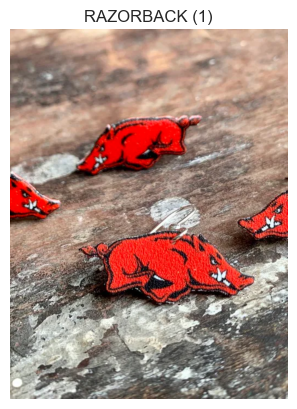

In [20]:
img_path = "Razorback_Images/razorback_5.jpg"    # path to any image you want

img = Image.open(img_path).convert("RGB")
tensor = transform_eval(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    prob = model(tensor).item()

print(f"Probability Razorback: {prob:.4f}")

label = "RAZORBACK (1)" if prob >= 0.5 else "NOT RAZORBACK (0)"
print("Prediction:", label)

plt.imshow(img)
plt.title(label)
plt.axis("off")
plt.show()

In [21]:
##Graph Outputs
output_dir = "presentation_figures"
os.makedirs(output_dir, exist_ok=True)

print("Saving PNGs to:", output_dir)

Saving PNGs to: presentation_figures


In [22]:
## Collect predictions & labels on test set
all_labels = []
all_probs = []
all_preds = []

model.eval()
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        # Model already ends with Sigmoid → these are probabilities
        probs = model(xb).squeeze()          # shape: [batch] or scalar
        preds = (probs >= 0.5).float()

        all_labels.extend(yb.cpu().numpy())
        all_probs.extend(probs.cpu().numpy().ravel())   # ensure 1D
        all_preds.extend(preds.cpu().numpy().ravel())

all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)
all_preds  = np.array(all_preds)

In [23]:
## Compute confusion matrix and ROC stats
cm = confusion_matrix(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print("Confusion matrix:\n", cm)
print("ROC AUC:", roc_auc)

Confusion matrix:
 [[4 1]
 [1 3]]
ROC AUC: 0.9


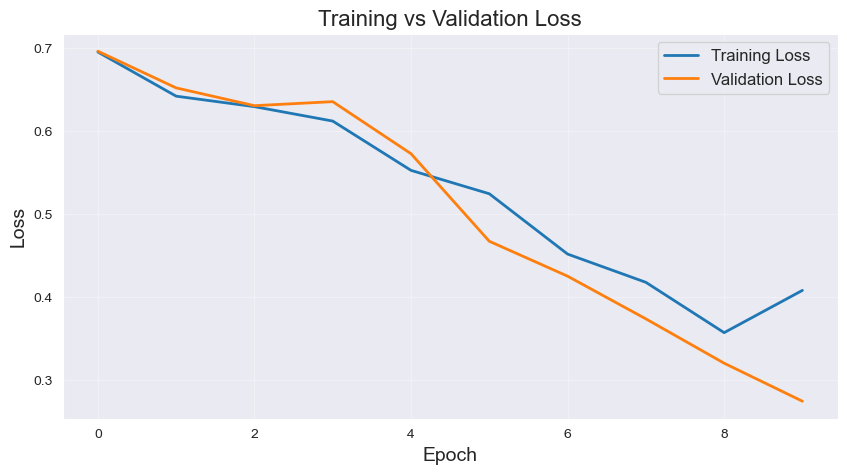

In [24]:
## Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(valid_losses, label="Validation Loss", linewidth=2)
plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.savefig(f"{output_dir}/loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

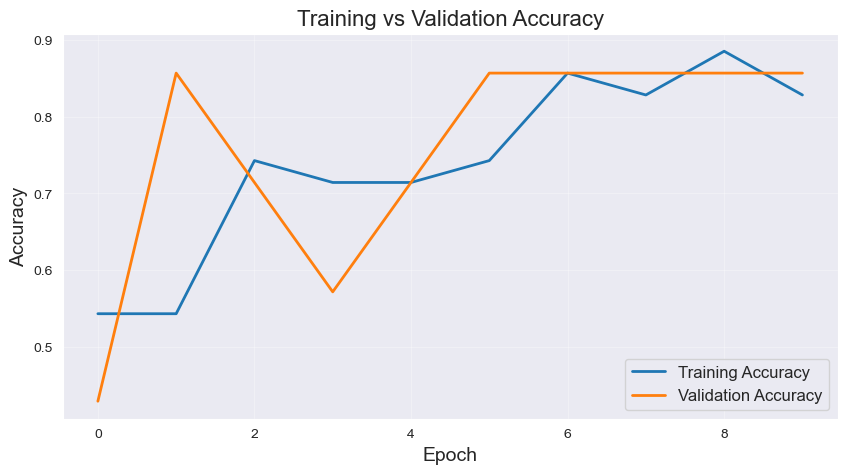

In [25]:
## Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Training Accuracy", linewidth=2)
plt.plot(valid_accs, label="Validation Accuracy", linewidth=2)
plt.title("Training vs Validation Accuracy", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.savefig(f"{output_dir}/accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.show()

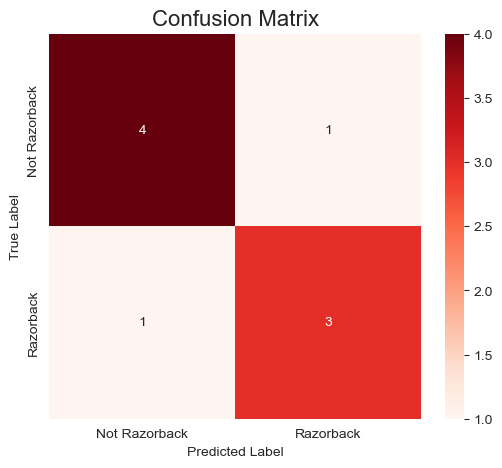

In [26]:
## Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Reds",
    xticklabels=["Not Razorback", "Razorback"],
    yticklabels=["Not Razorback", "Razorback"]
)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.savefig(f"{output_dir}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

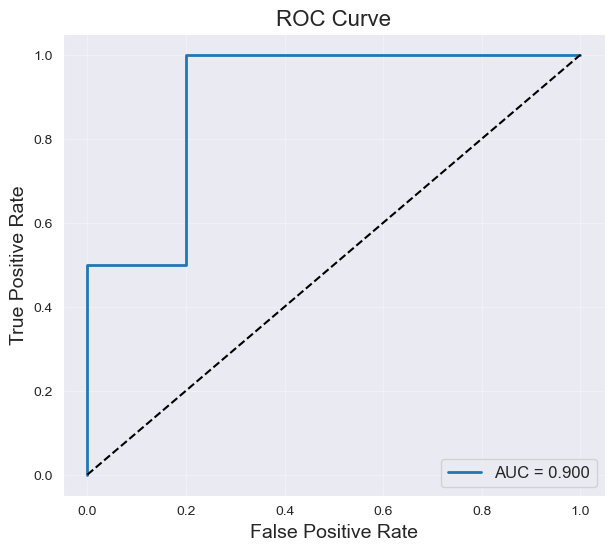

In [27]:
## ROC Curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

plt.savefig(f"{output_dir}/roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()

In [28]:
## Prediction Grid - get one batch
model.eval()
images, labels = next(iter(test_dl))
images = images.to(device)

with torch.no_grad():
    probs_batch = model(images).squeeze().cpu()

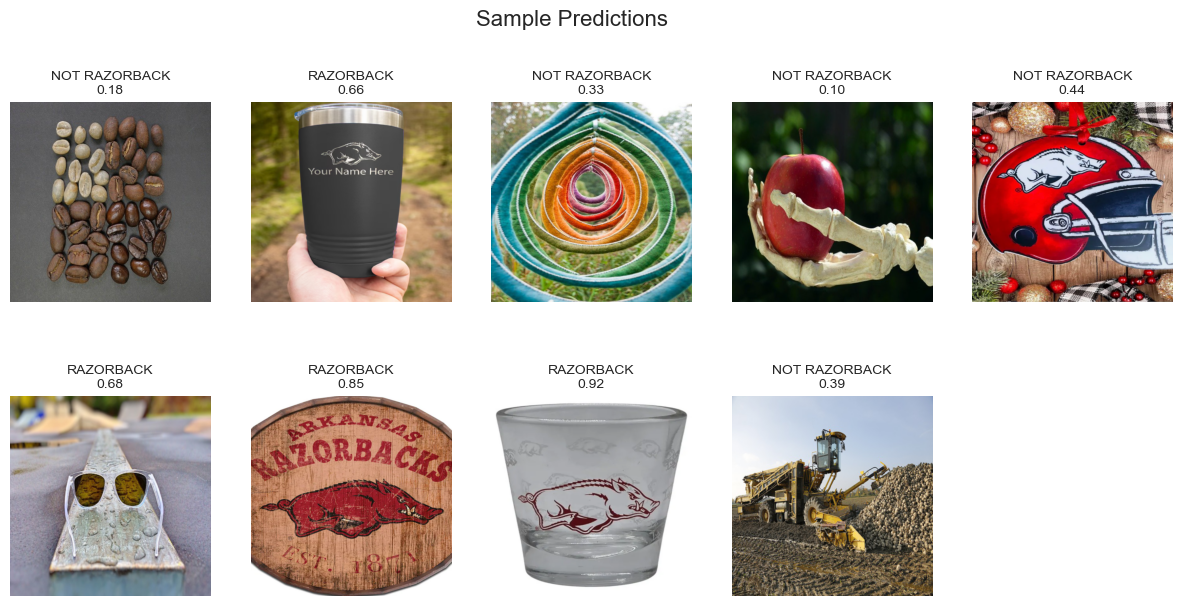

In [29]:
## Prediction Grid plot
plt.figure(figsize=(15, 7))

num_show = min(10, len(images))
for i in range(num_show):
    ax = plt.subplot(2, 5, i + 1)
    img = images[i].cpu().permute(1, 2, 0)
    plt.imshow(img)
    plt.axis("off")

    pred_prob = probs_batch[i].item()
    pred_label = "RAZORBACK" if pred_prob >= 0.5 else "NOT RAZORBACK"

    ax.set_title(f"{pred_label}\n{pred_prob:.2f}", fontsize=10)

plt.suptitle("Sample Predictions", fontsize=16)
plt.savefig(f"{output_dir}/predictions_grid.png", dpi=300, bbox_inches="tight")
plt.show()